In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

from torch.utils.data import random_split

import sys

import sklearn.metrics

import seaborn as sns

import time

## Subir datasets de fallas de corriente

In [ ]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_train.txt

Saving sensorless_tarea4_train.txt to sensorless_tarea4_train.txt


In [ ]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_test.txt

Saving sensorless_tarea4_test.txt to sensorless_tarea4_test.txt


## Leer datasets de fallas de corriente

In [ ]:
!ls

sample_data  sensorless_tarea4_test.txt  sensorless_tarea4_train.txt


In [ ]:
column_names = ["feat" + str(i) for i in range(48)]
column_names.append("class")

In [ ]:
df_train_val = pd.read_csv('sensorless_tarea4_train.txt', names = column_names)
df_train_val["class"] = df_train_val["class"] - 1
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,class
0,-7.614200e-06,0.000012,0.000049,-8.185500e-06,-6.508100e-07,0.000033,0.007024,0.007012,0.006964,0.006860,0.006861,0.006828,0.001104,0.000477,0.001328,0.001059,0.000538,0.001050,1.10290,1.10280,1.10270,1.10290,1.10290,1.10280,0.005135,0.045624,0.879800,0.007619,-0.079581,0.91917,-0.000023,-0.000039,-0.000107,-0.000728,-0.000714,-0.000721,-0.65823,0.30306,11.3400,-0.64611,5.33130,14.1750,-1.4983,-1.4983,-1.4986,-1.4989,-1.4989,-1.4990,2
1,-1.188700e-05,-0.000010,0.000049,5.824000e-06,6.078700e-06,0.000066,0.011934,0.011944,0.011895,-0.035653,-0.035659,-0.035726,0.001400,0.001214,0.002969,0.001416,0.000858,0.002591,2.14340,2.14330,2.14300,2.14000,2.13990,2.13960,0.007280,-0.711370,0.602100,-0.006534,0.002435,0.99354,-0.000165,-0.000154,-0.000244,-0.002406,-0.002400,-0.002596,-0.81004,17.06300,10.7140,-0.84380,7.68310,13.2590,-1.5010,-1.5011,-1.5009,-1.4998,-1.4998,-1.4998,5
2,7.533200e-06,0.000024,0.000682,1.138900e-05,2.162700e-05,0.000768,0.017291,0.017267,0.016585,-0.031898,-0.031919,-0.032687,0.002606,0.001408,0.006197,0.002533,0.001360,0.006613,1.78280,1.78270,1.78170,1.78540,1.78530,1.78430,-0.016708,0.282360,0.848730,-0.025321,0.335690,1.34290,-0.002998,-0.003014,-0.002745,0.014251,0.014206,0.014310,-0.63314,1.52980,4.5294,-0.61536,2.30320,9.0276,-1.5037,-1.5038,-1.5038,-1.4925,-1.4925,-1.4931,0
3,-9.354000e-06,0.000013,0.000041,-9.031300e-06,6.729700e-06,-0.000096,-0.021819,-0.021832,-0.021873,-0.019681,-0.019688,-0.019592,0.001252,0.000791,0.002514,0.001256,0.000890,0.002071,1.67230,1.67230,1.67210,1.67080,1.67070,1.67070,0.009053,-0.498520,1.735800,0.010976,-0.780170,-0.23747,-0.001654,-0.001663,-0.001725,-0.002757,-0.002761,-0.002824,-0.76557,12.00600,15.1530,-0.80057,22.09800,5.8399,-1.4984,-1.4984,-1.4981,-1.5005,-1.5005,-1.5002,1
4,-2.113300e-06,-0.000007,0.000011,3.844900e-06,3.006500e-06,-0.000006,0.055849,0.055856,0.055845,0.110200,0.110200,0.110200,0.000765,0.000239,0.000561,0.000759,0.000262,0.000612,0.85447,0.85447,0.85444,0.85605,0.85604,0.85601,0.009106,-0.667330,0.015859,-0.010013,2.092500,0.39424,0.010004,0.009992,0.009966,-0.002963,-0.002976,-0.002989,-0.60295,5.60500,4.0413,-0.61138,28.09900,7.4046,-1.4963,-1.4962,-1.4962,-1.4963,-1.4964,-1.4963,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,2.597600e-06,-0.000042,-0.000070,-7.258000e-07,7.886600e-06,0.000017,0.017540,0.017582,0.017651,0.064369,0.064362,0.064344,0.002244,0.001374,0.006840,0.002291,0.001352,0.002886,1.36820,1.36820,1.36680,1.37440,1.37430,1.37380,0.014984,-0.290590,-0.303640,0.008608,-0.006641,-0.27096,-0.003722,-0.003693,-0.003556,0.017623,0.017593,0.017757,-0.71249,3.70100,3.7355,-0.69067,4.14050,3.0060,-1.5077,-1.5078,-1.5071,-1.4970,-1.4971,-1.4969,3
3799,-9.429000e-06,0.000036,-0.000113,3.949600e-09,1.128600e-05,-0.000016,0.017520,0.017484,0.017597,-0.043423,-0.043434,-0.043418,0.001403,0.001243,0.002500,0.001418,0.000830,0.001846,2.14750,2.14750,2.14730,2.14500,2.14490,2.14470,-0.002614,0.432210,-0.682550,0.006220,0.033231,0.36118,0.001516,0.001483,0.001582,-0.001144,-0.001148,-0.001124,-0.81505,19.94200,4.0987,-0.83709,10.48900,9.7414,-1.5016,-1.5016,-1.5015,-1.4991,-1.4991,-1.4990,5
3800,9.998600e-06,0.000045,-0.000214,-4.555900e-06,4.670100e-05,0.000463,0.021856,0.021812,0.022025,-0.022194,-0.022241,-0.022704,0.002934,0.002096,0.005155,0.002900,0.001570,0.004612,2.22460,2.22450,2.22370,2.22690,2.22680,2.22560,-0.015325,0.367570,0.169010,-0.015717,0.066061,1.49260,0.002347,0.002301,0.002442,0.011669,0.011608,0.011163,-0.54685,17.05200,4.3626,-0.

In [ ]:
df_test = pd.read_csv('sensorless_tarea4_test.txt', names = column_names)
df_test["class"] = df_test["class"] - 1
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,class
0,-1.962500e-05,0.000009,-0.000282,-2.886400e-06,-0.000057,0.000036,0.024311,0.024302,0.024584,0.016004,0.016061,0.016025,0.002347,0.001223,0.003343,0.002345,0.001231,0.002030,1.5086,1.5086,1.5078,1.5060,1.5060,1.5056,0.029666,0.009763,-0.59801,0.000081,-0.30513,0.418060,-0.013167,-0.013176,-0.012521,0.002290,0.002369,0.002278,-0.68496,1.19680,3.7504,-0.69591,1.432900,1.8273,-1.4970,-1.4970,-1.4972,-1.5047,-1.5047,-1.5044,7
1,1.118000e-05,0.000005,-0.000229,-3.744300e-06,-0.000028,-0.000305,0.026031,0.026026,0.026255,0.011245,0.011273,0.011578,0.002287,0.001263,0.003828,0.002244,0.001247,0.003940,1.3948,1.3947,1.3941,1.4002,1.4001,1.3992,0.010690,0.372960,-0.13749,0.010543,0.02977,-1.161400,-0.006557,-0.006566,-0.006693,0.008656,0.008671,0.008565,-0.72004,3.02270,3.2997,-0.65935,-0.012139,5.7392,-1.5069,-1.5070,-1.5068,-1.4966,-1.4966,-1.4961,7
2,1.370700e-06,0.000085,-0.000175,2.215700e-07,0.000036,0.000090,0.024925,0.024840,0.025015,-0.045557,-0.045593,-0.045683,0.001398,0.001202,0.003187,0.001362,0.000929,0.002429,2.0044,2.0042,2.0039,2.0015,2.0015,2.0011,-0.007460,1.375900,-1.80920,0.006483,1.10240,0.652840,0.002014,0.001926,0.001959,-0.000146,-0.000193,-0.000230,-0.85169,19.66000,15.1090,-0.81652,12.246000,8.0125,-1.4991,-1.4991,-1.4988,-1.4989,-1.4989,-1.4990,0
3,-2.721900e-05,-0.000049,-0.000120,-2.189700e-06,0.000060,0.000091,-0.048451,-0.048402,-0.048282,-0.187390,-0.187450,-0.187540,0.002617,0.001637,0.005168,0.002720,0.001608,0.004935,1.9095,1.9095,1.9086,1.9049,1.9047,1.9040,0.039711,0.099896,0.25476,-0.001028,1.01430,-0.075783,0.005628,0.005674,0.005727,-0.023687,-0.023830,-0.024140,-0.59255,3.73110,6.6360,-0.59826,4.745700,11.0760,-1.5061,-1.5061,-1.5066,-1.4956,-1.4957,-1.4955,10
4,-1.957600e-05,0.000058,0.000073,-1.941400e-06,0.000168,-0.000099,0.019576,0.019518,0.019445,0.030496,0.030328,0.030427,0.002987,0.002113,0.006096,0.003024,0.002722,0.004346,2.3408,2.3405,2.3395,2.3391,2.3389,2.3384,0.018970,0.512830,0.66833,0.013142,1.95510,-0.491460,-0.003742,-0.003853,-0.003792,-0.011911,-0.012052,-0.011792,-0.52368,6.16790,19.6210,-0.47601,15.339000,6.5050,-1.5071,-1.5072,-1.5075,-1.4986,-1.4986,-1.4985,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,1.314500e-06,0.000044,0.000030,-1.794300e-05,-0.000016,-0.000085,0.010121,0.010076,0.010046,-0.037339,-0.037323,-0.037238,0.002271,0.001255,0.003356,0.002289,0.001287,0.003568,1.4312,1.4311,1.4305,1.4290,1.4290,1.4284,-0.019157,0.093751,-0.47094,0.007838,-0.64625,-0.384650,0.013590,0.013557,0.014003,-0.007084,-0.007089,-0.006871,-0.68346,0.41038,5.4617,-0.71229,3.777900,2.5630,-1.4986,-1.4986,-1.4983,-1.5025,-1.5025,-1.5022,5
1693,2.749800e-07,0.000024,0.000055,-5.288300e-06,-0.000007,0.000008,0.006574,0.006550,0.006495,0.010303,0.010310,0.010301,0.001119,0.000523,0.001031,0.001061,0.000518,0.001339,1.1063,1.1063,1.1062,1.1066,1.1066,1.1064,-0.008967,0.685240,0.59383,0.004092,-0.14380,0.177270,0.001743,0.001678,0.001686,0.002654,0.002681,0.002599,-0.71291,4.27590,9.0494,-0.65123,5.843700,10.0000,-1.4996,-1.4996,-1.4997,-1.4997,-1.4998,-1.4998,2
1694,-5.937400e-07,0.000041,0.000085,-2.074900e-06,0.000018,0.000012,-0.016098,-0.016139,-0.016224,-0.045576,-0.045594,-0.045606,0.002917,0.001746,0.005854,0.002977,0.001719,0.006193,2.2978,2.2977,2.2970,2.3017,2.3017,2.3005,-0.003918,-0.081557,-0.67577,-0.014602,0.12301,-0.443180,0.006562,0.006541,0.006011,-0.008857,-0.008860,-0.008776,-0.52237,1.14470,5.4140,-0.54716,2.158000,3.6216,-1.5077,-1.5077,-1.5077,-1.4981,-1.4981,-1.4982,1
1695,-2.4207

## Crear modelo

In [ ]:
model = nn.Sequential(
          nn.Linear(48, 40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,11)
        )

In [ ]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch

In [ ]:
# Crear datasets

feats_train_val = df_train_val.to_numpy()[:,0:48].astype(np.float32)
labels_train_val = df_train_val.to_numpy()[:,48].astype(int)
dataset_train_val = [ {"features":feats_train_val[i,:], "labels":labels_train_val[i]} for i in range(feats_train_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:48].astype(np.float32)
labels_test = df_test.to_numpy()[:,48].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

n_train = int(df_train_val.shape[0]*0.85)
n_val = df_train_val.shape[0] - n_train

dataset_train, dataset_val = random_split(dataset_train_val, [n_train, n_val])

In [ ]:
# Normalizar datos

fdata = []
i = 0

for x in dataset_train:
  fdata.append(x['features'])

fdata = np.array(fdata)

fmean= np.mean(fdata, axis=0)
fstd = np.std(fdata, axis=0)

for x in dataset_train:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_val:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_test:
  x['features'] = (x['features']-fmean) / fstd


In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento
Se puede interrumpir con: Entorno de Ejecución -> interrumpir la ejecución

In [ ]:
tiempo_ini = time.time()

prom_loss_train = [] #Promedio de loss del entrenamiento para cada epoca
prom_loss_vali = [] #Promedio del loss de validacion para cada epoca
epocas = range(49,1000,50)
prom_loss_train_def = [] #Promedio de loss cada 50 epocas (Entrenamiento)
prom_loss_vali_def = [] #Promedio loss cada 50 epocas (Validacion)
for epoch in range(1000):
    try:
      model.train()

      # Train on the current epoch
      loss_epoch_train = [] #Acá se guarda el loss de cada dato de la epoca
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)

          loss_train = criterion(outputs, labels) #calculo del loss de entrenamiento por dato
          loss_epoch_train.append(loss_train)     #guardamos el loss del dato en un vector
          loss_train.backward()                   
          optimizer.step()
      prom_train = sum(loss_epoch_train)/len(loss_epoch_train) #Calculamos el loss promedio de la epoca
      prom_loss_train.append(prom_train) #Guardamos el promedio en un vector

      # Compute validation loss and accuracy for current epoch
      model.eval()

      with torch.no_grad(): 
        loss_epoch_vali = [] #Acá se guarda el loss de cada dato de la epoca
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model(inputs)
            # Calcular loss de validación
            loss_vali = criterion(outputs, labels) #calculo del loss de validación por dato
            loss_epoch_vali.append(loss_vali)      #guargamos el loss del dato en un vector
        prom_vali = sum(loss_epoch_vali)/len(loss_epoch_vali) #Calculamos el loss promedio de la epoca
        prom_loss_vali.append(prom_vali)
      
      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)
      
      sys.stdout.write("\rÉpoca %d, loss entrenamiento %f, loss validacion %f" % (epoch, prom_train, prom_vali))

      #Hacemos el checkpoint cada 50 epocas y revisamos si debemos interrumpir el entrenamiento
      if epoch in epocas: 
        torch.save(model, 'red'+str(epocas.index(epoch))+'.pt')
        s_train = 0 #Suma de los loss de las 50 epocas anteriores (entrenamiento)
        s_vali = 0 #Suma de los loss de las 50 epocas anteriores (validacion)
        for i in range(epoch-50,epoch):
          s_train = prom_loss_train[i]+s_train
          s_vali = prom_loss_vali[i]+s_vali
        prome_train = s_train/50 #Loss promedio de las 50 epocas (Entrenamiento)
        prome_vali = s_vali/50 #Loss promedio de las 50 epocas (Validacion)
        prom_loss_train_def.append(prome_train)
        prom_loss_vali_def.append(prome_vali)
        #Si el loss de validacion actual es mayor que el de la vez pasada termino
        #El entrenamiento
        if prom_loss_vali_def[len(prom_loss_vali_def)-1] > prom_loss_vali_def[len(prom_loss_vali_def)-2]:
          print('\nEl loss de validacion empezo a aumentar en la epoca '+str(epoch))
          print('Por lo tanto nos quedaremos con la red de la epoca '+str(epoch-50))
          model = torch.load('red'+str(epocas.index(epoch)-1)+'.pt') #Nos quedamos con la red anterior
          break

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')
tiempo_fin = time.time()
print("El entrenamiento tardó: "+str(tiempo_fin-tiempo_ini))

Época 149, loss entrenamiento 0.005248, loss validacion 0.257333
El loss de validacion empezo a aumentar en la epoca 149
Por lo tanto nos quedaremos con la red de la epoca 99

Entrenamiento finalizado
El entrenamiento tardó: 8.9200119972229


Text(0.5, 1.0, 'Loss por epoca')

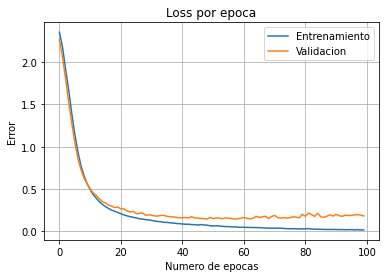

In [ ]:
#Grafico del loss por epoca
final = len(prom_loss_train)-50 #Esto es para graficar hasta el momento en que el loss fue minimo
plt.plot(range(final), prom_loss_train[:final], label='Entrenamiento')
plt.plot(range(final), prom_loss_vali[:final], label='Validacion')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Numero de epocas')
plt.ylabel('Error')
plt.title('Loss por epoca')

Cálculo de matriz de confusión y accuracy usando el conjunto de entrenamiento.


El accuracy de la red al usar el conjunto de entrenamiento es: 0.9978341584158416


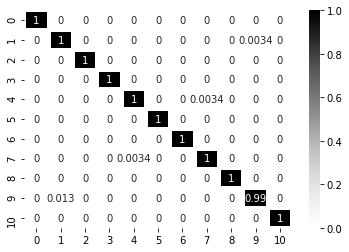

In [ ]:
predict_train = []
class_train = []
for i, data in enumerate(dataloader_train, 0):
  inputs = data["features"].to(device)
  labels = data["labels"].to(device)

  #Obtenemos las salidas
  outputs = model(inputs)
  #Obtenemos las predicciones
  pred = outputs.cpu().argmax(axis=1)
  #A continuacion obtendremos la prediccion hecha para cada elemento y la 
  #guardaremos en un vector, lo mismo hacemos con los labels
  for i in range(len(pred)):
    predict = pred[i].numpy().item()
    clas = labels[i].cpu().numpy().item()
    predict_train.append(predict)
    class_train.append(clas)

accuracy_train = sklearn.metrics.accuracy_score(class_train, predict_train, normalize=True)
print("El accuracy de la red al usar el conjunto de entrenamiento es: "+str(accuracy_train))
matrix_train = sklearn.metrics.confusion_matrix(class_train, predict_train, normalize='true')
sns.heatmap(matrix_train, linewidths=3, annot=True, cmap="Greys")

Cálculo de matriz de confusión y accuracy para el conjunto de validación.

El accuracy de la red al usar el conjunto de validacion es: 0.9527145359019265


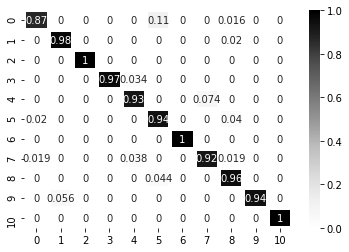

In [ ]:
predict_vali = []
class_vali = []
for i, data in enumerate(dataloader_val, 0):
  inputs = data["features"].to(device)
  labels = data["labels"].to(device)

  #Obtenemos las salidas
  outputs = model(inputs)
  #Obtenemos las predicciones
  pred = outputs.cpu().argmax(axis=1)
  #A continuacion obtendremos la prediccion hecha para cada elemento y la 
  #guardaremos en un vector, lo mismo hacemos con los labels
  for i in range(len(pred)):
    predict = pred[i].numpy().item()
    clas = labels[i].cpu().numpy().item()
    predict_vali.append(predict)
    class_vali.append(clas)

accuracy_vali = sklearn.metrics.accuracy_score(class_vali, predict_vali, normalize=True)
print("El accuracy de la red al usar el conjunto de validacion es: "+str(accuracy_vali))
matrix_vali = sklearn.metrics.confusion_matrix(class_vali, predict_vali, normalize='true')
sns.heatmap(matrix_vali, linewidths=3, annot=True, cmap="Greys")

Cálculo de matriz de confusión y accuracy para el conjunto de prueba.

El accuracy de la red al usar el conjunto de prueba es: 0.9569829110194461


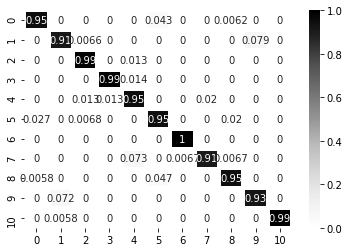

In [ ]:
predict_test = []
class_test = []
for i, data in enumerate(dataloader_test, 0):
  inputs = data["features"].to(device)
  labels = data["labels"].to(device)

  #Obtenemos las salidas
  outputs = model(inputs)
  #Obtenemos las predicciones
  pred = outputs.cpu().argmax(axis=1)
  #A continuacion obtendremos la prediccion hecha para cada elemento y la 
  #guardaremos en un vector, lo mismo hacemos con los labels
  for i in range(len(pred)):
    predict = pred[i].numpy().item()
    clas = labels[i].cpu().numpy().item()
    predict_test.append(predict)
    class_test.append(clas)

accuracy_test = sklearn.metrics.accuracy_score(class_test, predict_test, normalize=True)
print("El accuracy de la red al usar el conjunto de prueba es: "+str(accuracy_test))
matrix_test = sklearn.metrics.confusion_matrix(class_test, predict_test, normalize='true')
sns.heatmap(matrix_test, linewidths=3, annot=True, cmap="Greys")